# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# from sklearn.mixture import GMM
# I got lots of deprecation warnings for GMM so I switched this for GaussianMixture
from sklearn.mixture import GaussianMixture

from matplotlib.colors import LogNorm


Load feature names.

In [2]:
feature_names = []

with open('../Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)


Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('../Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape


(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

First 1 principal components account for 0.2973 of the total variance
First 2 principal components account for 0.399 of the total variance
First 3 principal components account for 0.4696 of the total variance
First 4 principal components account for 0.5083 of the total variance
First 5 principal components account for 0.5451 of the total variance
First 6 principal components account for 0.5764 of the total variance
First 7 principal components account for 0.6037 of the total variance
First 8 principal components account for 0.6299 of the total variance
First 9 principal components account for 0.6522 of the total variance
First 10 principal components account for 0.6727 of the total variance
First 11 principal components account for 0.6914 of the total variance
First 12 principal components account for 0.7087 of the total variance
First 13 principal components account for 0.7256 of the total variance
First 14 principal components account for 0.7408 of the total variance
First 15 princip

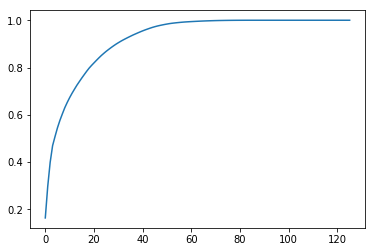

In [4]:
def P1():
### STUDENT START ###

    # Fit PCA to the training data
    pca = PCA().fit(train_data)
    
    # Print the fraction of variables explained by the first k principal components
    for k in range(1, 51):
        print 'First {} principal components account for {:.4} of the total variance'.format(k, np.cumsum(pca.explained_variance_ratio_)[k])
    
    # Plot the cumulative sum of the variance explained by the first k principal components
    plt.plot(np.cumsum(pca.explained_variance_ratio_))

### STUDENT END ###

P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

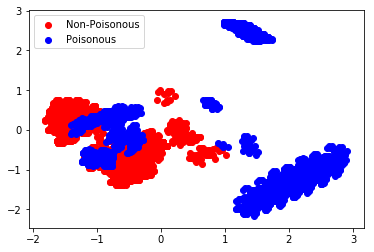

In [5]:
def P2():
### STUDENT START ###

    # Fit PCA to the training data in 2 dimensions
    pca = PCA(n_components = 2).fit_transform(train_data)

    plt.figure()
    
    for c, i, target_name in zip("rb", [0, 1], ['Non-Poisonous', 'Poisonous']):
        plt.scatter(pca[train_labels == i, 0], pca[train_labels == i, 1], c = c, label = target_name)
    
    plt.legend()
    plt.show()

### STUDENT END ###

P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

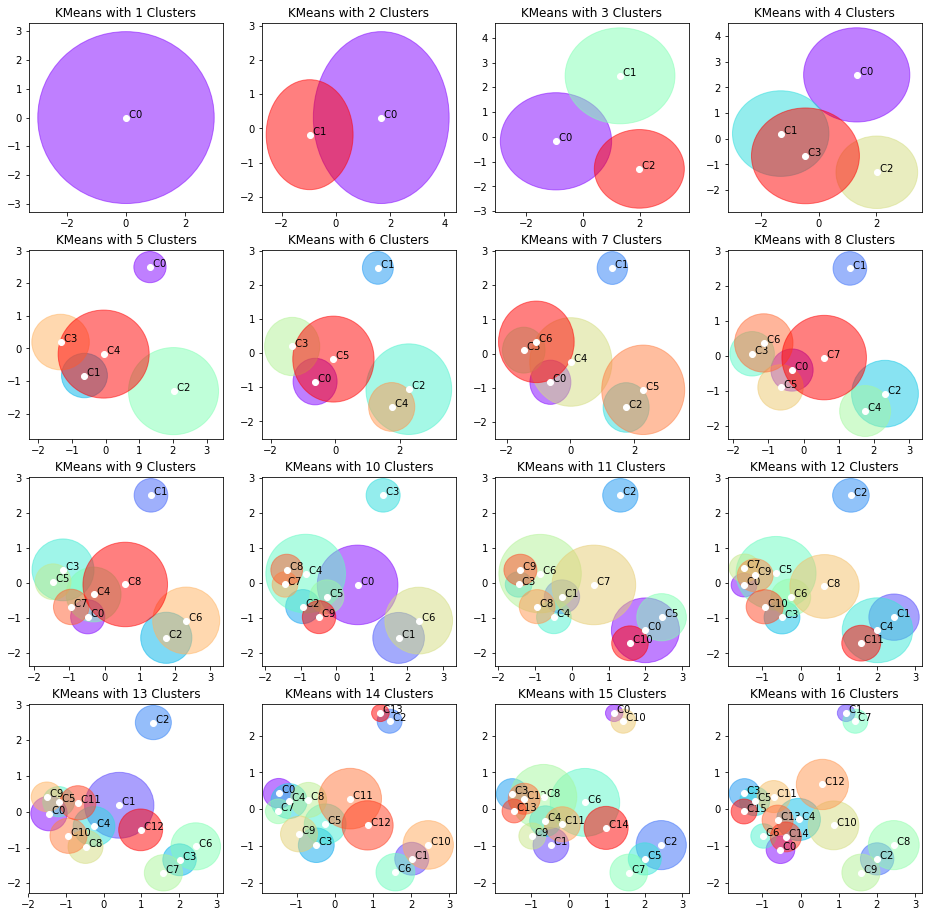

In [6]:
def P3():
### STUDENT START ###

    # Specify the number of subplots
    nrow    = 4
    ncol    = 4
    fig, ax = plt.subplots(nrow, ncol, figsize = (16, 16))
    
    # Project the data to 2D
    pca = PCA(n_components = 2).fit_transform(train_data)

    for i in range(16):
        km        = KMeans(n_clusters = i + 1).fit(pca)
        centroids = km.cluster_centers_
        dists     = km.transform(pca)
        
        # Set a color scale to more easily distinguish the clusters
        color = plt.cm.rainbow(np.linspace(0, 1, i + 1))
        
        for j in range(i + 1):
            # The radius is the maximum of the minimum distances in each point's distance list to the centroids
            radius = max([min(k) for k in dists[km.labels_ == j]])
            circle = plt.Circle((centroids[j][0], centroids[j][1]), radius = radius, alpha = 0.5, color = color[j])
            
            # Set the axes of the subplot, checking if the range should be expanded
            current_xlim = ax[i / nrow, i % ncol].get_xlim()
            current_ylim = ax[i / nrow, i % ncol].get_ylim()
                
            ax[i / nrow, i % ncol].set_xlim((min(centroids[j][0] - 1.1 * radius, current_xlim[0]),\
                                             max(centroids[j][0] + 1.1 * radius, current_xlim[1])))
            ax[i / nrow, i % ncol].set_ylim((min(centroids[j][1] - 1.1 * radius, current_ylim[0]),\
                                             max(centroids[j][1] + 1.1 * radius, current_ylim[1])))
                
            # Add the next circle to the subplot and plot the centroid with a white dot
            ax[i / nrow, i % ncol].add_artist(circle)
            ax[i / nrow, i % ncol].scatter(centroids[j][0], centroids[j][1], marker = 'o', color = 'w', zorder = 10)
            ax[i / nrow, i % ncol].annotate(' C' + str(j), (centroids[j][0], centroids[j][1]))
            ax[i / nrow, i % ncol].set_title('KMeans with ' + str(i + 1) + ' Clusters')
        
### STUDENT END ###

P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:1537: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


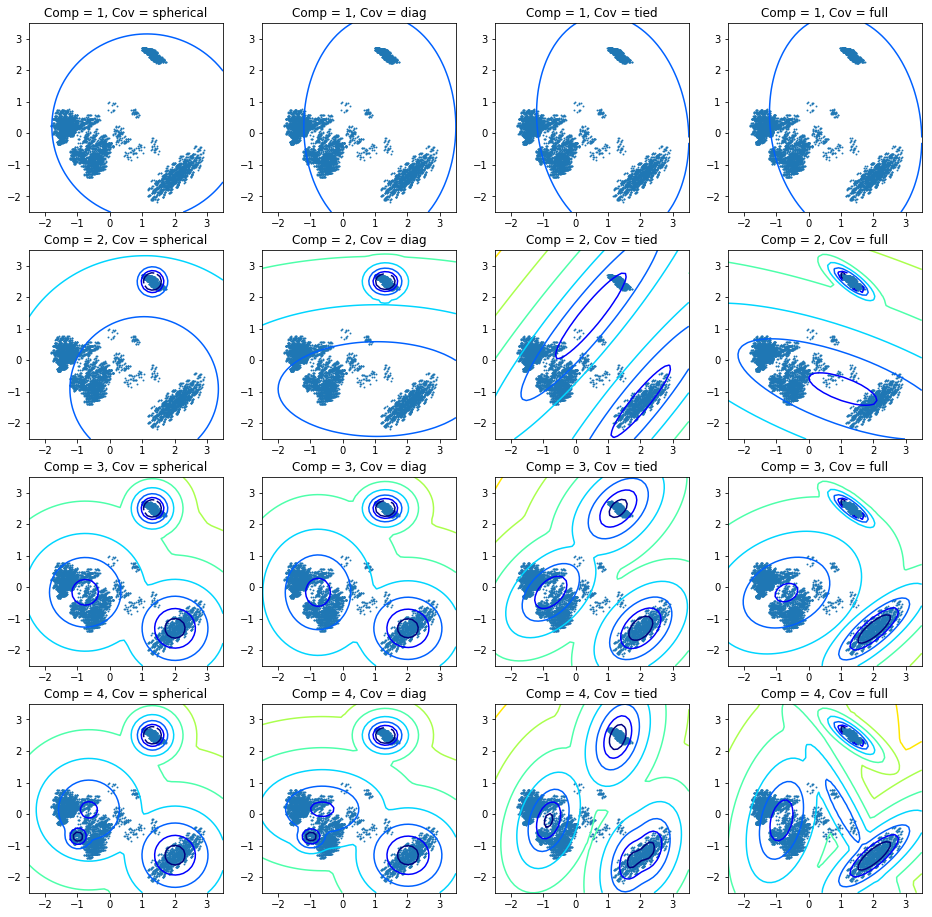

In [7]:
def P4():
### STUDENT START ###

    # Fit PCA to the training data in 2 dimensions
    pca = PCA(n_components = 2).fit_transform(train_data)
    
    # Specify the number of subplots
    nrow    = 4
    ncol    = 4
    fig, ax = plt.subplots(nrow, ncol, figsize = (16, 16))
    
    for i in range(nrow):
        for j in range(4):
            cov_type = ['spherical', 'diag', 'tied', 'full'][j]
            GM       = GaussianMixture(n_components = i + 1, covariance_type = cov_type).fit(pca[train_labels == 1])
            
            # Create the sample set
            x    = np.linspace(-2.5, 3.5)
            y    = np.linspace(-2.5, 3.5)
            X, Y = np.meshgrid(x, y)
            XX   = np.array([X.ravel(), Y.ravel()]).T
            Z    = -GM.score_samples(XX)
            Z    = Z.reshape(X.shape)
            
            # Display the scatterplot with the contour lines
            ax[i, j].contour(X, Y, Z, norm = LogNorm(vmin = 1.0, vmax = 1000.0), levels = np.logspace(0, 3, 10),\
                             cmap = plt.cm.jet)
            ax[i, j].scatter(pca[:, 0], pca[:, 1], .8)
            ax[i, j].set_title('Comp = ' + str(i + 1) + ', Cov = ' + cov_type)

### STUDENT END ###

P4()

As the number of components increase, we see a much better contour for the GaussianMixture model.

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [8]:
def P5():
### STUDENT START ###

    # Fit PCA to the training data in 2 dimensions
    pca    = PCA(n_components = 2).fit(train_data)
    GM_neg = GaussianMixture(n_components = 4, covariance_type = 'full', random_state = 0)\
             .fit(pca.transform(train_data[train_labels == 0]))
    GM_pos = GaussianMixture(n_components = 4, covariance_type = 'full', random_state = 0)\
             .fit(pca.transform(train_data[train_labels == 1]))
    
    # Calculate the probabilities using GaussianMixture.score(), and the predictions for the highest value
    pca_test   = pca.transform(test_data)
    neg_scores = GM_neg.score_samples(pca_test)
    pos_scores = GM_pos.score_samples(pca_test)
    preds      = [1 if pos_scores[i] > neg_scores[i] else 0 for i in range(len(neg_scores))]
    
    # Calculate the accuracy
    print 'The accuracy of the combined models is {}'.format(metrics.accuracy_score(preds, test_labels))
    
### STUDENT END ###

P5()

The accuracy of the combined models is 0.950177935943


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [9]:
def P6():
### STUDENT START ###

    accuracy_parameters = []

    for i in range(1, 10):
        for j in range(1, 25):
            if (i + j) * 2 > 50:
                break
            
            for k in range(4):
                # Fit PCA to the training data in 2 dimensions
                pca      = PCA(n_components = i).fit(train_data)
                cov_type = ['spherical', 'diag', 'tied', 'full'][k]
                GM_neg   = GaussianMixture(n_components = j, covariance_type = cov_type, random_state = 0)\
                           .fit(pca.transform(train_data[train_labels == 0]))
                GM_pos   = GaussianMixture(n_components = j, covariance_type = cov_type, random_state = 0)\
                           .fit(pca.transform(train_data[train_labels == 1]))

                # Calculate the probabilities using GaussianMixture.score(), and the predictions for the highest value
                pca_test   = pca.transform(test_data)
                neg_scores = GM_neg.score_samples(pca_test)
                pos_scores = GM_pos.score_samples(pca_test)
                preds      = [1 if pos_scores[m] > neg_scores[m] else 0 for m in range(len(neg_scores))]

                # Calculate the accuracy
                accuracy_parameters.append([metrics.accuracy_score(preds, test_labels), i, j, cov_type])
    
    sorted_accuracies = sorted(accuracy_parameters, reverse = True)
    
    # Print the top 5 accuracies
    for o in sorted_accuracies[0:50]:
        print 'The accuracy is {} for {} PCA Comps, {} GaussianMixture Comps, and Cov Type of {}'.format(o[0], o[1], o[2], o[3])
    
### STUDENT END ###

P6()

The accuracy is 1.0 for 9 PCA Comps, 16 GaussianMixture Comps, and Cov Type of full
The accuracy is 1.0 for 9 PCA Comps, 15 GaussianMixture Comps, and Cov Type of full
The accuracy is 1.0 for 9 PCA Comps, 14 GaussianMixture Comps, and Cov Type of full
The accuracy is 1.0 for 9 PCA Comps, 10 GaussianMixture Comps, and Cov Type of full
The accuracy is 1.0 for 9 PCA Comps, 9 GaussianMixture Comps, and Cov Type of full
The accuracy is 1.0 for 9 PCA Comps, 8 GaussianMixture Comps, and Cov Type of full
The accuracy is 1.0 for 8 PCA Comps, 17 GaussianMixture Comps, and Cov Type of full
The accuracy is 1.0 for 8 PCA Comps, 16 GaussianMixture Comps, and Cov Type of full
The accuracy is 1.0 for 8 PCA Comps, 15 GaussianMixture Comps, and Cov Type of full
The accuracy is 1.0 for 8 PCA Comps, 13 GaussianMixture Comps, and Cov Type of full
The accuracy is 1.0 for 8 PCA Comps, 11 GaussianMixture Comps, and Cov Type of full
The accuracy is 1.0 for 7 PCA Comps, 17 GaussianMixture Comps, and Cov Type of

For computing purposes, I only included PCA components up to 10 as it took significantly longer after that.

Several model combinations yielded accuracies of 100. Despite the random seed parameter being 0 during all my runs, not all combinations continuously had the same accuracy. However, the model with 8 / 9 PCA Components, 8 / 9 GausianMixture components, and Covariance of full continuously yielded accuracies of, or just below, 100.